In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [3]:
def zero_pad(X, pad):
    
    X_pad = np.pad(X, ((0,0), (pad, pad), (pad, pad), (0,0)), mode='constant', constant_values = (0,0))
    
    return X_pad

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)
x[1,1] =
 [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] =
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


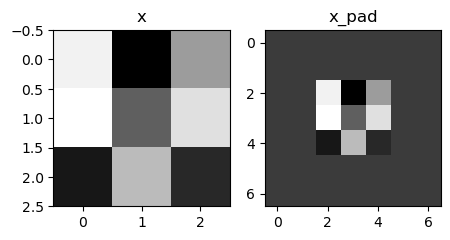

In [4]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
print ("x[1,1] =\n", x[1,1])
print ("x_pad[1,1] =\n", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

In [5]:
def conv_single_step(a_slice_prev, W, b):
    
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

In [6]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


In [8]:
def conv_forward(A_prev, W, b, hparameters):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape[0], A_prev.shape[1], A_prev.shape[2], A_prev.shape[3]
    (f, f, n_C_prev, n_C) = W.shape[0], W.shape[1], W.shape[2], W.shape[3]
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev - f + 2*pad)/stride) + 1
    n_W = int((n_W_prev - f + 2*pad)/stride) + 1
    
    Z = np.zeros([m, n_H, n_W, n_C])
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            vert_start = stride * h
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = stride * w
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_slice_prev = A_prev_pad[i, vert_start:vert_end, horiz_start:horiz_end, :]
                    weights = W[:, :, :, c]
                    biases = b[:, :, :, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)
                                        
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576932
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


In [11]:
def pool_forward(A_prev, hparameters, mode = "max"):
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              
    
    for i in range(m):
        for h in range(n_H):
            vert_start = h * stride
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = w * stride
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [12]:
# Case 1: stride of 1
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 1, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 3, 3, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.46210794 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.14472371 0.90159072 2.10025514]
   [1.14472371 0.90159072 1.65980218]
   [1.14472371 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 0.84616065 1.2245077 ]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.84616065 1.27375593]
   [1.96710175 0.84616065 1.23616403]
   [1.62765075 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.96710175 0.86888616 1.23616403]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 3, 3, 3)
A =
 [[[[-3.01046719e-02 -3.24021315e-03 -3.36298859e-01]
   [ 1.43310483e-01  1.93146751e-01 -4.44905196e-01]
   [ 1.28934436e-01  2.22428468e-01  1.25067597e-01]]

  [[-3.81801899e-01  1.59993515e-02  1.70562706e-01]
   [

In [13]:
# Case 2: stride of 2
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print("A =\n", A)
print()

A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))
print("A =\n", A)

mode = max
A.shape = (2, 2, 2, 3)
A =
 [[[[1.74481176 0.90159072 1.65980218]
   [1.74481176 1.6924546  1.65980218]]

  [[1.13162939 1.51981682 2.18557541]
   [1.13162939 1.6924546  2.18557541]]]


 [[[1.19891788 0.84616065 0.82797464]
   [0.69803203 1.12141771 1.2245077 ]]

  [[1.96710175 0.86888616 1.27375593]
   [1.62765075 1.12141771 0.79280687]]]]

mode = average
A.shape = (2, 2, 2, 3)
A =
 [[[[-0.03010467 -0.00324021 -0.33629886]
   [ 0.12893444  0.22242847  0.1250676 ]]

  [[-0.38268052  0.23257995  0.6259979 ]
   [-0.09525515  0.268511    0.46605637]]]


 [[[-0.17313416  0.32377198 -0.34317572]
   [ 0.02030094  0.14141479 -0.01231585]]

  [[ 0.42944926  0.08446996 -0.27290905]
   [ 0.15077452  0.28911175  0.00123239]]]]
